In [56]:
from pathlib import Path

import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmrotate.models import build_detector
from mmrotate import obb2poly_np
import cv2
import numpy as np
import scipy
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
!mim download mmrotate --config oriented_rcnn_r50_fpn_1x_dota_le90 --dest .

In [15]:
def load_model():
    # Choose to use a config and initialize the detector
    config = 'oriented_rcnn_r50_fpn_1x_dota_le90.py'
    # Setup a checkpoint file to load
    checkpoint = 'oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'

    # Set the device to be used for evaluation
    device='cpu'

    # Load the config
    config = mmcv.Config.fromfile(config)
    # Set pretrained to be None since we do not need pretrained model here
    config.model.pretrained = None

    # Initialize the detector
    model = build_detector(config.model)

    # Load checkpoint
    checkpoint = load_checkpoint(model, checkpoint, map_location=device)

    # Set the classes of models for inference
    model.CLASSES = checkpoint['meta']['CLASSES']

    # We need to set the model's cfg for inference
    model.cfg = config

    # Convert the model to GPU
    model.to(device)
    # Convert the model into evaluation mode
    model.eval()

    return model

In [18]:
def detect_vehicles(image_path, model):

    result = inference_detector(model, image_path)

    return result

In [ ]:
def create_vehicle_thumbnails(image_path, obbs, output_dir):
    vehicle_obbs = np.concatenate((obbs[4], obbs[5]))
    if vehicle_obbs.size == 0:
        print(f"No vehicles detected in image {image_path}")
        return None
    polygons = obb2poly_np(vehicle_obbs, version="le90")
    polygons = np.delete(polygons, [8], axis=1)
    for idx, p in enumerate(polygons):
        try:
            polygon_coords = [(p[i],  p[i+1]) for i in range(0, len(p), 2)]
            image = cv2.imread(image_path)
            pts = np.array([polygon_coords], dtype=np.int32)
            x, y, w, h = cv2.boundingRect(pts)
            cropped = image[y:y+h, x:x+w]
            img_id = image_path.stem
            filename = f"{img_id}-{idx}.png"
            cv2.imwrite(Path(output_dir) / filename, cropped)
        except Exception as e:
            print(f"Error: {e} while processing polygon {p} in image {image_path}.")

In [39]:
def match_color(bgr):
    color_options = {
        "black": (0, 0, 0),
        "white": (255, 255, 255),
        "gray": (128, 128, 128),
        "silver": (192, 192, 192),
        "blue": (255, 0, 0),
        "red": (0, 0, 255),
        "brown": (42, 42, 165),
        "gold": (0, 215, 255),
        "green": (0, 255, 0),
        "tan": (140, 180, 210),
        "orange": (0, 165, 255),
        "yellow": (0, 255, 255)
    }
    min_distance = 1000000
    color_match = None
    for name, values in color_options.items():
        distance = scipy.spatial.distance.euclidean(bgr, values)
        if distance < min_distance:
            min_distance = distance
            color_match = name
    
    return color_match

In [ ]:
def identify_color(image, polygon_coords):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    pts = np.array([polygon_coords], dtype=np.int32)

    # Fill the polygon on the mask
    cv2.fillPoly(mask, pts, 255)

    mean_val = cv2.mean(image, mask=mask)
    bgr = mean_val[:3]
    return match_color(bgr)

In [46]:
def create_vehicle_data(image_path, obbs, output_dir):
    vehicle_obbs = np.concatenate((obbs[4], obbs[5]))
    if vehicle_obbs.size == 0:
        print(f"No vehicles detected in image {image_path}")
        return None
    polygons = obb2poly_np(vehicle_obbs, version="le90")
    polygons = np.delete(polygons, [8], axis=1)
    for idx, p in enumerate(polygons):
        try:
            polygon_coords = [(p[i],  p[i+1]) for i in range(0, len(p), 2)]
            image = cv2.imread(image_path)
            color = identify_color(image, polygon_coords)
            le90 = np.delete(vehicle_obbs[idx], [5])
            img_id = image_path.stem
            filepath = Path(output_dir) / f"{img_id}-{idx}.txt"
            with open(filepath, "w") as f:
                f.write("0 ") # dummy class
                f.write(' '.join(map(str, le90)))
                f.write(f" {color}")
        except Exception as e:
            print(f"Error: {e} while processing polygon {p} in image {image_path}.")

## Example image

In [ ]:
model = load_model()

In [52]:
path = Path("data/2.png")
output_dir = Path("output")
if not output_dir.exists():
    output_dir.mkdir(parents=True)
obbs = detect_vehicles(path, model)
create_vehicle_thumbnails(path, obbs, output_dir)
create_vehicle_data(path, obbs, output_dir)

Error processing polygon [  2.6033 363.246   23.5603 375.3667  18.0054 384.9714  -2.9516 372.8507] in image data/2.png.


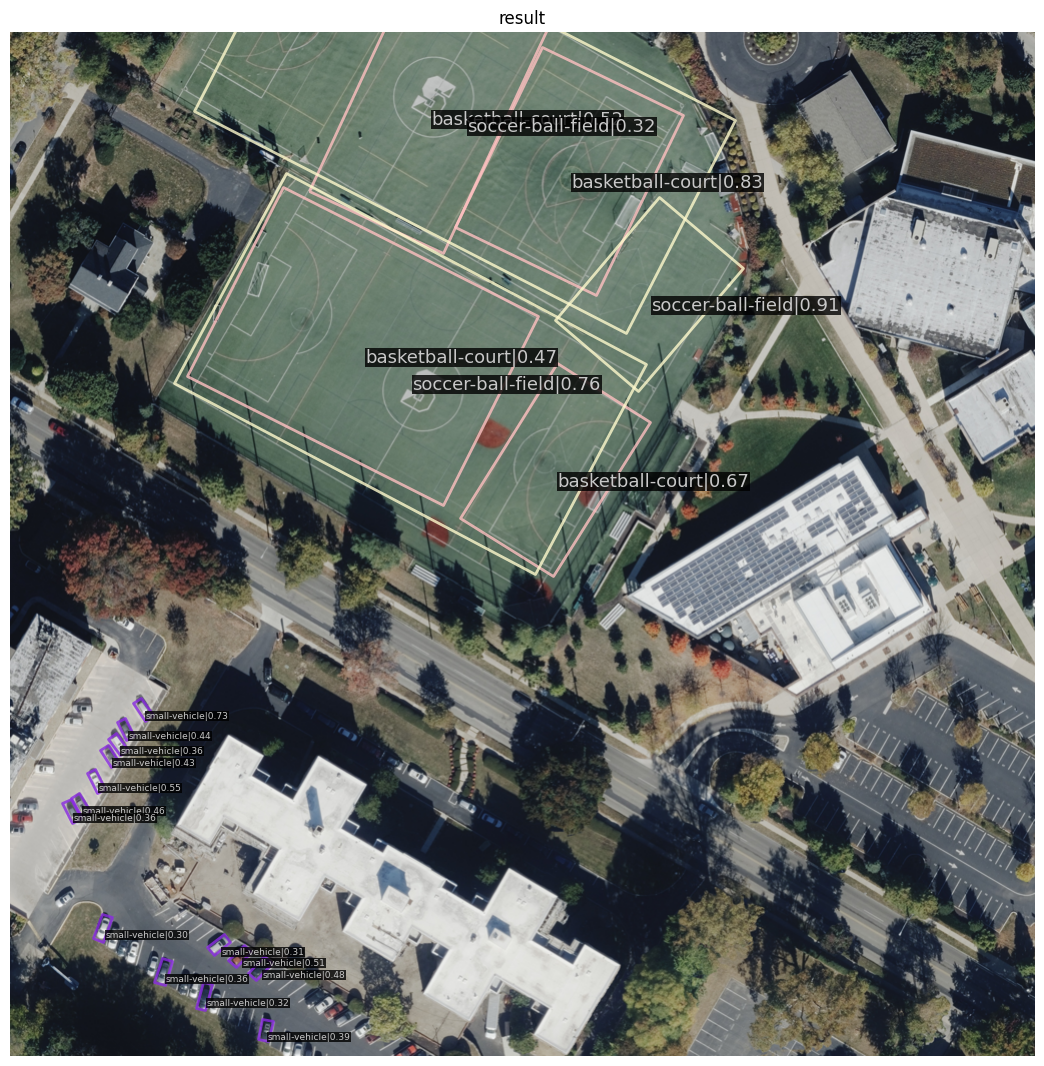

In [53]:
show_result_pyplot(model, path, obbs, score_thr=0.3, palette='dota')

In [54]:
thumbnail = cv2.imread("output/2-0.png")

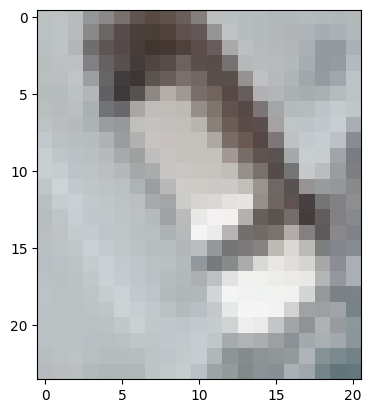

In [57]:
plt.imshow(thumbnail)

In [58]:
with open("output/2-0.txt") as f:
    print(f.readline())

0 133.53313 677.76556 20.955366 9.455748 0.9930898 silver


## Run on all images

In [42]:
image_paths = Path("data").glob("*.png")

In [16]:
model = load_model()

/home/keenan/miniconda3/envs/vehicle-detect/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth


In [27]:
output_dir = Path("output")
if not output_dir.exists():
    output_dir.mkdir(parents=True)

In [47]:
for path in tqdm(image_paths):
    obbs = detect_vehicles(path, model)
    create_vehicle_thumbnails(path, obbs, output_dir)
    create_vehicle_data(path, obbs, output_dir)

0it [00:00, ?it/s]/home/keenan/miniconda3/envs/vehicle-detect/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
1it [00:08,  8.04s/it]

Error processing polygon [ 12.786  640.997   22.1422 648.2477   6.2628 668.7381  -3.0934 661.4874] in image data/26.png.
Error processing polygon [-4.6907e-01  9.1242e+02  1.5599e+01  9.2578e+02  9.3805e+00  9.3326e+02 -6.6876e+00  9.1989e+02] in image data/26.png.


2it [00:17,  8.62s/it]

Error processing polygon [  2.6033 363.246   23.5603 375.3667  18.0054 384.9714  -2.9516 372.8507] in image data/2.png.


9it [01:17,  8.39s/it]

Error processing polygon [  5.0753 143.9666  13.6282 147.1358   1.7136 179.2899  -6.8392 176.1207] in image data/33.png.


10it [01:22,  7.36s/it]

Error processing polygon [358.0548  -2.9566 372.5248   8.2227 367.1938  15.1229 352.7238   3.9436] in image data/19.png.
Error processing polygon [320.3516 -11.6867 337.2741   2.5851 328.577   12.8976 311.6544  -1.3743] in image data/19.png.


14it [01:49,  6.42s/it]

Error processing polygon [ -2.1044 585.7396   7.3944 581.2587  17.192  602.028    7.6932 606.5089] in image data/10.png.


18it [02:16,  6.46s/it]

No vehicles detected in image data/32.png
No vehicles detected in image data/32.png


23it [02:57,  8.41s/it]

Error processing polygon [141.1897  -2.2178 151.6128   1.1921 143.795   25.0882 133.3719  21.6782] in image data/14.png.


24it [03:11, 10.00s/it]

Error processing polygon [ 8.3908e-01  8.7661e+02  2.0360e+01  8.8584e+02  1.6528e+01  8.9394e+02 -2.9925e+00  8.8472e+02] in image data/3.png.


25it [03:19,  9.54s/it]

Error processing polygon [  7.7909 434.7876  15.8614 438.9375   5.2811 459.5138  -2.7894 455.3639] in image data/30.png.


28it [03:51,  9.84s/it]

Error processing polygon [ 8.8984e+02 -6.8433e+00  9.0457e+02  6.5502e+00  8.9814e+02  1.3616e+01  8.8341e+02  2.2259e-01] in image data/11.png.


32it [04:30,  9.58s/it]

Error processing polygon [  5.9341 739.3008  15.4239 744.5908   5.6239 762.1711  -3.8659 756.8811] in image data/4.png.
Error processing polygon [  7.8727 709.1391  17.276  713.2857   8.1082 734.0755  -1.2951 729.9289] in image data/4.png.
Error processing polygon [74.4141 -6.3212 94.4009  5.6384 88.449  15.5852 68.4622  3.6256] in image data/4.png.
Error processing polygon [ -3.4844 882.6263   4.0143 875.3185  20.4885 892.223   12.9898 899.5309] in image data/4.png.


35it [05:01,  9.53s/it]

Error processing polygon [ -1.218  670.9506  14.5409 655.5186  22.3332 663.476    6.5742 678.908 ] in image data/13.png.
Error processing polygon [ -1.5097 340.0266  16.8578 352.1393  10.8829 361.1994  -7.4845 349.0868] in image data/13.png.


36it [05:20, 12.46s/it]

Error processing polygon [ 993.1091   -8.6662 1018.4147    6.4552 1011.0244   18.8229  985.7187    3.7015] in image data/6.png.
Error processing polygon [431.7638  -6.5184 440.4008  -1.2614 427.8991  19.2783 419.2621  14.0213] in image data/6.png.


39it [05:55,  9.11s/it]


## Notes

- Development process
    - I first investigated what pretrained models exist that could already be used for this task
    - MMRotate is widely used and has several pretrained models for OBB detection to choose from, so I decided to try this. I picked a model that had intermediate results on their benchmarks.
    - I tested it on a couple of images and saw that it has moderate success detecting vehicles, but tends to miss vehicles where contrast is poor - either bright background or shadow.
    - After this I worked on building everything end to end needed to do color detection and output the results.
- Next Steps
    - With more time, I would go back and do a more thorough investigation of existing models, choosing a metric and evaluating them on the provided dataset.
    - From there, assuming the model predictions still need improvement, I would do some experiments comparing fine-tuning pretrained models and training models from scratch. Since these pretrained models are trained to predict several classes that aren't relevant to this problem, I could probably get better results tuning the final classification layers to predict just the classes that we need.
    - Color identification also needs improvement. Averaging the pixels and choosing the nearest color worked alright for a start, but is often thrown off by different colored pixels right around the car and by the car windshield (for example a white car often shows up as gray due to the black windshield pixels averaging with the car color). A couple of possibilities for improvement includes using the mode pixel value instead of average and eroding the edge of the polygon to remove background pixels.